# A simple binary classification example to demonstate how LoRA works

LoRA: Low-Rank Adaptation of Large Language Models
Edward J. Hu*, Yelong Shen*, Phillip Wallis, Zeyuan Allen-Zhu, Yuanzhi Li, Shean Wang, Lu Wang, Weizhu Chen
Paper: https://arxiv.org/abs/2106.09685

## Import libraries and build two data generating mechanism
 - Uniformly-distributed data on a sphere of radius 1
 - Gaussian-distributed data
 - labels: {-1, 1}, generated by using the sign function of the mean of data over all its dimensions

In [155]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random
from collections import OrderedDict
import math
import torch.nn.functional as F
random.seed(42)


def generate_uniform_sphere(n, d):
    normal_data = np.random.normal(loc=0.0, scale=1.0, size=[n, d])
    lambdas = np.sqrt((normal_data * normal_data).sum(axis=1))
    data = np.sqrt(d) * normal_data / lambdas[:, np.newaxis]
    return data


# data type could be "uniform" or "gaussian"
def data_generator(data_type='uniform', inp_dims=100, sample_size=10000):
    if data_type == 'uniform':
        data = generate_uniform_sphere(sample_size, inp_dims)
    elif data_type == 'gaussian':
        var = 1.0 / inp_dims
        data = np.random.normal(loc=0.0, scale=var, size=[sample_size, inp_dims])

    labels = np.sign(np.mean(data, -1))
    for i in range(sample_size):
        if labels[i] == 0:
            labels[i] = 1
    return data, labels

## Visualise 3-dimensional uniform vectors on a sphere

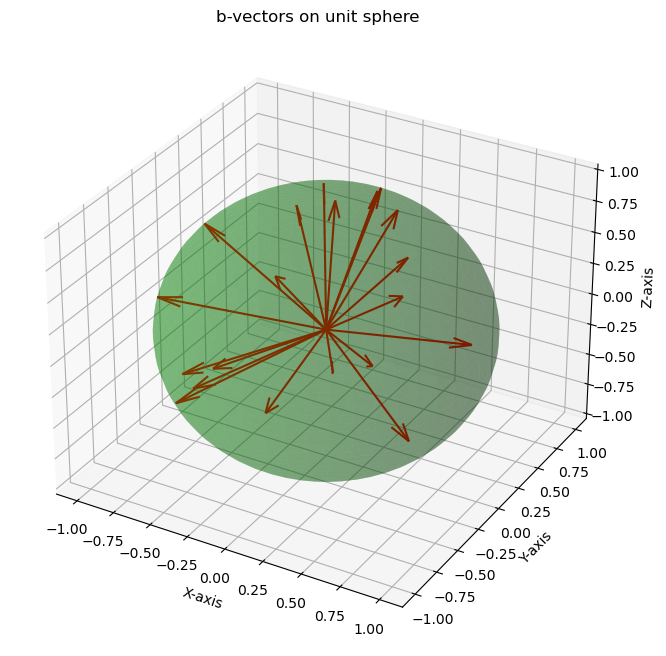

In [156]:
def draw_unit_vector_on_sphere(bvecs):
    """
    an array of 3D coordinates in [-1,1]
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    # alpha controls opacity
    ax.plot_surface(x, y, z, color="g", alpha=0.3)

    # tails of the arrows
    tails= np.zeros(len(bvecs))

    # heads of the arrows with adjusted arrow head length
    ax.quiver(tails,tails,tails,bvecs[:,0], bvecs[:,1], bvecs[:,2],
              length=1.0, normalize=True, color='r', arrow_length_ratio=0.15)

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.set_title('b-vectors on unit sphere')

    plt.show()

data_plot = generate_uniform_sphere(20, 3)
draw_unit_vector_on_sphere(data_plot)

## Build a simple 3-layer ReLu MLP as our model
 - the training objective is the log loss
 - the evaluation function computes the number of correctly classfied labels

In [ ]:
class ReluNN(torch.nn.Module):
    def __init__(self, inp_dims, h_dims, out_dims=1):
        super(ReluNN, self).__init__()
        self.inp_dims = inp_dims
        self.h_dims = h_dims
        self.out_dims = out_dims
        
        # build model
        self.layer1 = torch.nn.Linear(self.inp_dims, self.h_dims)
        self.layer2 = torch.nn.Linear(self.h_dims, self.h_dims)
        self.last_layer = torch.nn.Linear(self.h_dims, self.out_dims, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, start_dim=1)
        x = self.layer1(x)
        x = torch.nn.ReLU()(x)
        x = self.layer2(x)
        x = torch.nn.ReLU()(x)
        x = self.last_layer(x)
        return x

def calc_loss(logits, labels):
    return torch.mean(torch.log(1 + torch.exp(-1 * torch.mul(labels.float(), logits.T))))


def evaluate(labels, loss=None, output=None, iter=0, training_time=True):
    correct_label_count = 0
    for i in range(len(output)):
        if (output[i] * labels[i] > 0).item():
            correct_label_count += 1
    if training_time:
        print('Iteration: ', iter, ' Loss: ', loss, ' Correct label: ', correct_label_count, '/', len(output))
    else:
        print('Correct label:  ', correct_label_count, '/', len(output), '， Accuracy: ', correct_label_count / len(output))


## Write a simple training loop to first classify the uniformly distributed data

In [139]:
# input dimensions
inp_dims = 16
# hidden dimensions in our model
h_dims = 32
# training sample size
n_train = 2000
# starting learning rate (I didn't end up using any learning rate scheduler. So this will be constant. )
starting_lr = 1e-4
batch_size = 256

# generate data and build pytorch data pipline using TensorDataset module
data_train, labels_train = data_generator(data_type="uniform", inp_dims=inp_dims, sample_size=n_train)
dataset = TensorDataset(torch.Tensor(data_train), torch.Tensor(labels_train))
loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)

# Build the model and define optimiser
model = ReluNN(inp_dims, h_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=starting_lr)


# ---------------------
# Training loop here
# ---------------------

its = 0
epochs = 400
print_freq = 200

for epoch in range(epochs):
    for batch_data, batch_labels in loader:
        optimizer.zero_grad()
        output = model(batch_data)
        loss = calc_loss(output, batch_labels)
        loss.backward()
        optimizer.step()
        
        if its % print_freq == 0:
            correct_labels = evaluate(labels=batch_labels, loss=loss.detach().numpy(), 
                                      output=output, iter=its, training_time=True)

        its += 1

Iteration:  0  Loss:  0.7003881  Correct label:  116 / 256
Iteration:  200  Loss:  0.65986  Correct label:  185 / 256
Iteration:  400  Loss:  0.52235454  Correct label:  231 / 256
Iteration:  600  Loss:  0.32558757  Correct label:  239 / 256
Iteration:  800  Loss:  0.22638851  Correct label:  244 / 256
Iteration:  1000  Loss:  0.15673004  Correct label:  246 / 256
Iteration:  1200  Loss:  0.13573596  Correct label:  249 / 256
Iteration:  1400  Loss:  0.09116879  Correct label:  253 / 256
Iteration:  1600  Loss:  0.06916265  Correct label:  254 / 256
Iteration:  1800  Loss:  0.049332645  Correct label:  255 / 256
Iteration:  2000  Loss:  0.045859627  Correct label:  255 / 256
Iteration:  2200  Loss:  0.04725042  Correct label:  255 / 256
Iteration:  2400  Loss:  0.039421413  Correct label:  255 / 256
Iteration:  2600  Loss:  0.044547867  Correct label:  255 / 256


In [157]:
print('-------------------------------------------------')
print('Test model performance on uniformly-distributed data (the data we trained our model on)')
data_test, labels_test = data_generator(data_type="uniform", inp_dims=inp_dims, sample_size=1024)
data_test = torch.Tensor(data_test)
labels_test = torch.Tensor(labels_test)

output = model(data_test)
correct_labels = evaluate(labels=labels_test, loss=0.0, output=output, iter=0, training_time=False)

print('-------------------------------------------------')
print('Test model performance on normally-distributed data')
data_test, labels_test = data_generator(data_type="gaussian", inp_dims=inp_dims, sample_size=1024)
data_test = torch.Tensor(data_test)
labels_test = torch.Tensor(labels_test)

output = model(data_test)
correct_labels = evaluate(labels=labels_test, loss=0.0, output=output, iter=0, training_time=False)
print('-------------------------------------------------')

-------------------------------------------------
Test model performance on uniformly-distributed data (the data we trained our model on)
Correct label:   1004 / 1024 ， Accuracy:  0.98046875
-------------------------------------------------
Test model performance on normally-distributed data
Correct label:   933 / 1024 ， Accuracy:  0.9111328125
-------------------------------------------------


#### It's not a surprise that the model performs better on the uniformly-distributed test data, since it has the same distribution as our training data. Next, we will try to use LoRA to fine tune the model, and see if we can improve the accuracy on Gaussian data.  

## First, let's see what the model structure looks like:

In [142]:
print(model)

ReluNN(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (last_layer): Linear(in_features=32, out_features=1, bias=False)
)


## Wrap a linear layer into a "LoRA linear layer"

As a simple demonstration, we will only use LoRA on the second layer of our model. 

The code is an adaption from the official implementation by the LoRA authors: https://github.com/microsoft/LoRA/tree/main

In [149]:
class LoRALinear(torch.nn.Linear):
    def __init__(
        self, 
        layer: torch.nn.Linear, 
        r: int, 
        lora_alpha: float, 
        in_features: int, 
        out_features: int,
        **kwargs, 
    ):
        torch.nn.Linear.__init__(self, in_features, out_features, **kwargs)

        # trainable parameters
        self.r = r
        if self.r > 0:
            # lora_A matrix has shape [number of ranks, number of input features]
            self.lora_A = torch.nn.Parameter(self.weight.new_zeros((r, in_features)))
            
            # lora_A matrix has shape [number of output features, number of ranks]
            self.lora_B = torch.nn.Parameter(self.weight.new_zeros((out_features, r)))
            
            self.scaling = lora_alpha / r
            
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
            
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            torch.nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            torch.nn.init.zeros_(self.lora_B)

    def forward(self, x: torch.Tensor):
        if self.r > 0:
            result = F.linear(x, self.weight, bias=self.bias)            
            result += (x @ self.lora_A.transpose(0, 1) @ self.lora_B.transpose(0, 1)) * self.scaling
            return result
        else:
            return F.linear(x, self.weight, bias=self.bias)

## Wrap the second layer in LoRA linear layer with rank 2

We see that the accuracy on Gaussian data has reduced to 74.7%, in comparison to 91.1% using the previous model.  This is because we initialised the LoRA weights, which are just random at this point, and added them to the previously trained weights of this layer.  

In [150]:
ranks = 2
l_alpha = 1.0

# wrap the second layer of the model
lora_layer2 = LoRALinear(model.layer2, r=ranks, lora_alpha=l_alpha, in_features=h_dims, out_features=h_dims)

# run the new model and compare the results
x = model.layer1(data_test)
x = torch.nn.ReLU()(x)
# ---this is the new layer---
x = lora_layer2(x)
# ---------------------------
x = torch.nn.ReLU()(x)
output = model.last_layer(x)
correct_labels = evaluate(labels=labels_test, loss=0.0, output=output, iter=0, training_time=False)

Correct label:   765 / 1024 ， Accuracy:  0.7470703125


## Compare the numbers of trainable parameters

- the original layer has 1056 parameters, i.e., 32 x 32 + 32 (bias).
- using Lora, we actually only need to update 160 parameters instead.  This is ~15% of the original papameter count of this layer. This is how LoRA speeds up the computation, especially when it comes to large models.    

In [158]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("Original second layer parameters: ", count_parameters(model.layer2))
print("LoRA layer parameters: ", count_parameters(lora_layer2))

Original second layer parameters:  1056
LoRA layer parameters:  160


## Fine-tuning 

Okay. We got everything.  Let's build a new dataset for the Gaussian distributed data, and fine-tune the second layer of our model. 

In [152]:
# new pipline that contains data generated from Gaussian distribution
ft_data_train, ft_labels_train = data_generator(data_type="gaussian", inp_dims=inp_dims, sample_size=n_train)
ft_data_test, ft_labels_test = data_generator(data_type="gaussian", inp_dims=inp_dims, sample_size=n_train)
dataset = TensorDataset(torch.Tensor(ft_data_train), torch.Tensor(ft_labels_train))
ft_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False)

# Adam now takes the 160 trainable LoRA parameters 
starting_lr = 1e-3
optimizer = torch.optim.Adam(lora_layer2.parameters(), lr=starting_lr)

# ---------------------
# Training starts again
# ---------------------

its = 0
epochs = 400
print_freq = 200

for epoch in range(epochs):
    for batch_data, batch_labels in ft_loader:
        optimizer.zero_grad()
        
        x = model.layer1(batch_data)
        x = torch.nn.ReLU()(x)
        # ---this is the new layer---
        x = lora_layer2(x)
        # ---------------------------
        x = torch.nn.ReLU()(x)
        output = model.last_layer(x)
        
        loss = calc_loss(output, batch_labels)
        loss.backward()
        optimizer.step()
        
        if its % print_freq == 0:
            correct_labels = evaluate(labels=batch_labels, loss=loss.detach().numpy(), 
                                      output=output, iter=its, training_time=True)

        its += 1

Iteration:  0  Loss:  0.69509035  Correct label:  133 / 256
Iteration:  200  Loss:  0.5370997  Correct label:  252 / 256
Iteration:  400  Loss:  0.32091013  Correct label:  254 / 256
Iteration:  600  Loss:  0.20924407  Correct label:  254 / 256
Iteration:  800  Loss:  0.15160276  Correct label:  254 / 256
Iteration:  1000  Loss:  0.117958024  Correct label:  255 / 256
Iteration:  1200  Loss:  0.09627219  Correct label:  255 / 256
Iteration:  1400  Loss:  0.08122836  Correct label:  255 / 256
Iteration:  1600  Loss:  0.07015164  Correct label:  255 / 256
Iteration:  1800  Loss:  0.061670613  Correct label:  255 / 256
Iteration:  2000  Loss:  0.05496759  Correct label:  255 / 256
Iteration:  2200  Loss:  0.049540706  Correct label:  255 / 256
Iteration:  2400  Loss:  0.045049794  Correct label:  255 / 256
Iteration:  2600  Loss:  0.041265376  Correct label:  255 / 256
Iteration:  2800  Loss:  0.03803003  Correct label:  255 / 256
Iteration:  3000  Loss:  0.035230998  Correct label:  255 

## Training looks good!  Let's check the test accuracy on our new data. 

It went up to 98.9% from the previous 91.1%.  

In [153]:
data_test, labels_test = data_generator(data_type="gaussian", inp_dims=inp_dims, sample_size=1024)
data_test = torch.Tensor(data_test)
labels_test = torch.Tensor(labels_test)

x = model.layer1(data_test)
x = torch.nn.ReLU()(x)
# ---this is the new layer---
x = lora_layer2(x)
# ---------------------------
x = torch.nn.ReLU()(x)
output = model.last_layer(x)
correct_labels = evaluate(labels=labels_test, loss=0.0, output=output, iter=0, training_time=False)

Correct label:   1013 / 1024 ， Accuracy:  0.9892578125


### The accuracy for uniform data went down from 98% to 96.8%.  But that's okay!  We now have a model adapted to our new task. 

In [154]:
data_test, labels_test = data_generator(data_type="uniform", inp_dims=inp_dims, sample_size=1024)
data_test = torch.Tensor(data_test)
labels_test = torch.Tensor(labels_test)

x = model.layer1(data_test)
x = torch.nn.ReLU()(x)
# ---this is the new layer---
x = lora_layer2(x)
# ---------------------------
x = torch.nn.ReLU()(x)
output = model.last_layer(x)
correct_labels = evaluate(labels=labels_test, loss=0.0, output=output, iter=0, training_time=False)

Correct label:   991 / 1024 ， Accuracy:  0.9677734375
